# Forecasting of Industrial Production of Electric and Gas Utilities

This file contains codes which builds a model that forecasts the industrial production of electric and gas utilities given monthly production units from January 1939 to September 2022. Statistical approaches SARIMA and Prophet are compared to identify the best performing approach for the model. To achieve this, the following tasks are performed:
1. Importing libraries and data file
2. Data profiling and time series data conversion 
3. Handling missing values
4. Exploratory data analysis
5. Stationarity, autocorrelation and seasonality analysis
6. Forecasting using SARIMA
7. Forecasting using Prophet
8. Visualizing the model performance

## Importing Libraries and Data

In [154]:
import pandas as pd
import numpy as np
from pandas import read_csv
import time
from pandas import datetime
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from prophet import Prophet 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
df = read_csv('C:/Users/tomna/Desktop/Notebooks/Industrial Production of Electric and Gas Utilities/final_data.csv')
df.head()

,Observation_Date,Production_Index
0,01/01/1939,3.3335
1,01/02/1939,3.3590
2,01/03/1939,3.4353
3,01/04/1939,3.4607
4,01/05/1939,3.4607


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Observation_Date  1005 non-null   object 
 1   Production_Index  1005 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [156]:
# converting date column to standard date/time format
df['Observation_Date'] = pd.to_datetime(df['Observation_Date'], format='%d/%m/%Y')  # m for month, M for min
df_prophet = df.copy()    # copy the dataframe for prediction analysis using prophet in the later section
df = df.set_index('Observation_Date')
df = df.asfreq('MS', fill_value=np.nan)  # set the series frequency as month, starting at the first day of each month
df = df.sort_index()  # sort df by index in ascending order
df

,Production_Index
Observation_Date,
1939-01-01,3.3335
1939-02-01,3.3590
1939-03-01,3.4353
1939-04-01,3.4607
1939-05-01,3.4607
...,...
2022-05-01,93.8455
2022-06-01,104.5226
2022-07-01,115.5735


In [157]:
# confirming the set index
pd.infer_freq(df.index)

'MS'

In [158]:
#verify that the series is complete, covering all dates in the range
missing_dates = pd.date_range(df.index.min(), df.index.max(), freq=df.index.freq).difference(df.index).to_list()
if len(missing_dates) == 0:
    print('The series is complete!')
else:
    print('The series is INCOMPLETE!! The following times are missing: ', missing_dates)

The series is complete!


In [159]:
# check missing values in the Production_Index column
df.isnull().sum()

Production_Index    0
dtype: int64

## Exploratory Data Analysis

### General Data Analysis

In [160]:
# extracting additional columns for data analysis
df['Month'] = df.index.month
df['Year'] = df.index.year
df.head()

,Production_Index,Month,Year
Observation_Date,,,
1939-01-01,3.3335,1,1939
1939-02-01,3.3590,2,1939
1939-03-01,3.4353,3,1939
1939-04-01,3.4607,4,1939
1939-05-01,3.4607,5,1939


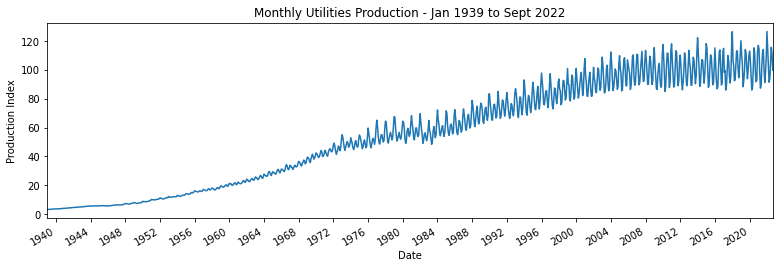

In [161]:
# plotting monthly production of the entire dataset
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(df['Production_Index'])
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_title('Monthly Utilities Production - Jan 1939 to Sept 2022')
fig.suptitle('')
ax.set_xlim(pd.to_datetime('1939-01-01'), pd.to_datetime('2022-09-01')) # limiting index period for visual clarity
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
# auto format font and rotation for date tick labels
plt.gcf().autofmt_xdate() 
plt.show()

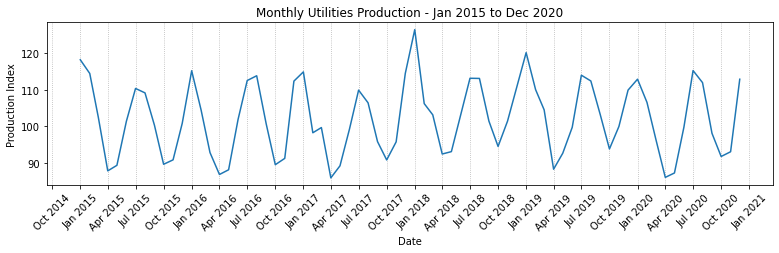

In [162]:
# Zooming a section of dataset for sectional observation
fig, ax = plt.subplots(figsize=(13,3))
ax.plot(df.loc['2015-01-01':'2020-12-31']['Production_Index']) # slicing data by index
ax.grid(axis='x', ls=':')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index") 
ax.set_title('Monthly Utilities Production - Jan 2015 to Dec 2020')
fig.suptitle('')
# set x-axis major ticks to monthly interval
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,3)))  # from month 1 to 12 by the interval of 3
# format x-tick labels as 3-letter month name and year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params('x', labelrotation=45)
plt.show()

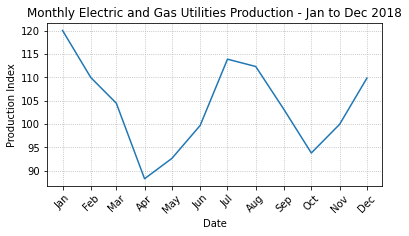

In [163]:
# Further zooming of a data section
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(df.loc['2019-01-01':'2019-12-31']['Production_Index']) # slicing data by index
ax.grid(True, ls=':')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index") 
ax.set_title('Monthly Electric and Gas Utilities Production - Jan to Dec 2018')
fig.suptitle('')
# set x-axis major ticks to monthly interval
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# format x-tick labels as a 3-letter month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.tick_params('x', labelrotation=45)
plt.show()

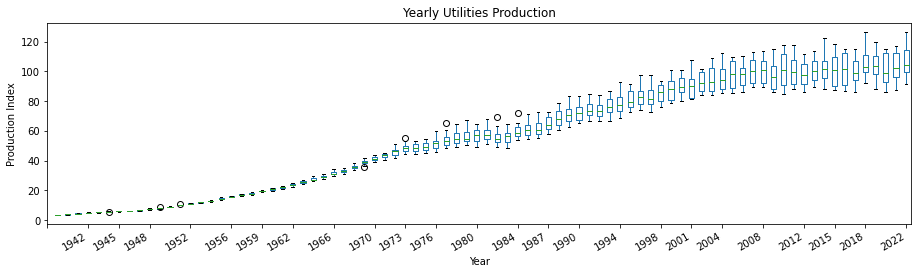

In [164]:
# plotting the production by year
fig, ax = plt.subplots(figsize=(15,4))
df.boxplot(column='Production_Index', by='Year', ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Production Index") 
ax.set_title('Yearly Utilities Production')
fig.suptitle('')
ax.grid(False)
# limit number of x ticks to display
#ax.xaxis.set_major_locator(plt.MaxNLocator(25))
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(int(xmin), int(xmax), 25)))   # show 25 ticks
# auto format font and rotation for date tick labels
plt.gcf().autofmt_xdate() 
plt.show()

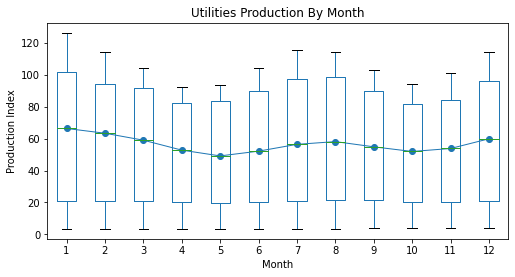

In [165]:
# plotting the production by month
df.boxplot(column='Production_Index', by='Month', grid=False)
df.groupby('Month')['Production_Index'].median().plot(style='o-', linewidth=1.0)
plt.xlabel('Month')
plt.ylabel('Production Index')
plt.title("Utilities Production By Month")
plt.suptitle("")
plt.gcf().set_size_inches(8,4)
plt.show()

The general observation is that the production has been continuously increasing from 1939 to 2022. This is likely due to the increase in the population thus the number of consumers. Winter and summer months are observed to yield peak production for obvious reasons, that is, a high demand of energy to home consumers to warm and cool their homes during winter and summer periods respectively. This trend appears to repetitive in each year.

### Stationarity, Autocorrelation and Seasonality Analysis

#### Stationarity

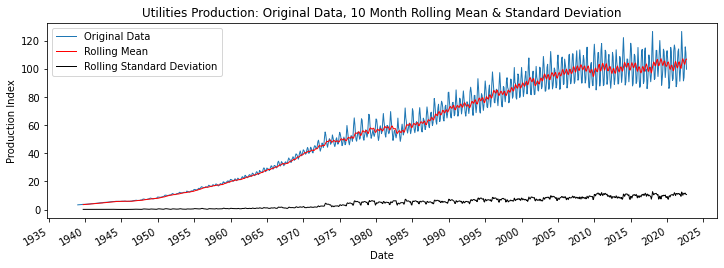

In [166]:
# plotting original data, and rooling mean and standard deviation to analyse stationarity
lags = 10   # set the lag time as a 10 month period
rolling_mean = df['Production_Index'].rolling(lags).mean()
rolling_std = df['Production_Index'].rolling(lags).std()
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df['Production_Index'], label="Original Data", linewidth=1.0)
ax.plot(rolling_mean, color="red", label="Rolling Mean", linewidth=1.0)
ax.plot(rolling_std, color="black", label = "Rolling Standard Deviation", linewidth=1.0)
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_title('Utilities Production: Original Data, 10 Month Rolling Mean & Standard Deviation')
fig.suptitle('')
# set yearly locators
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.legend(loc='best')
# auto format font and rotation for date tick labels
plt.gcf().autofmt_xdate() 
plt.show()

The mean production of 10 month rolling period is observed to be increasing drastically over the years. The standard deviation of data in the same time window appears to be increasing slightly from 1973. This indicates an upward trend in the data thus the series is not stationary.

#### Autocorrelation

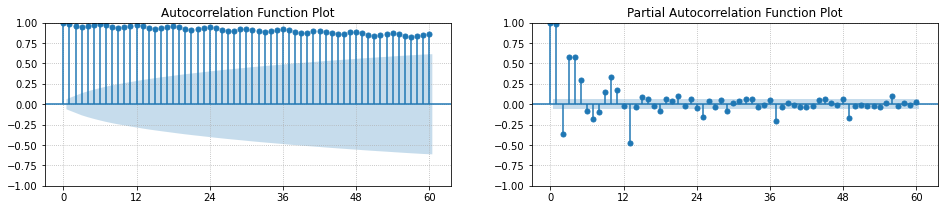

In [167]:
#  we plot autocorrelation and partial autocorrelation function plots to analyse autocorrelation, stationarity and seasonality behaviours of the series
fig, axes = plt.subplots(1,2, figsize=(16,3), constrained_layout=True)
lags = 60
plot_acf(df['Production_Index'], ax=axes[0], lags=lags)
axes[0].set_title('Autocorrelation Function Plot')
axes[0].grid(True, ls=':')
axes[0].set_xticks(np.arange(0, lags + 1, 12))  # specify xticks from 0 to the lag range by a difference of 12 months so as to observe seasonality 
plot_pacf(df['Production_Index'], ax=axes[1], lags=lags)
axes[1].set_title('Partial Autocorrelation Function Plot')
axes[1].grid(True, ls=':')
axes[1].set_xticks(np.arange(0, lags + 1, 12))
plt.subplots_adjust(wspace=0.2)
plt.show()

The autocorrelation plot shows that there are strong positive correlations between the current lags and the previous ones across all first 60 lags as all correlation values are well above 95% confidence interval. It can also be seen that there is a slow decrease in the values as lags increase (instead of sharp decrease), indicating a trend in the series. This suggests that the series is likely to be non-stationary. We can also see a seasonality being depicted by the plot by repetitive peaks and dips of correlation values at constant lag intervals. The partial autocorrelation plot, on the other hand, shows correlations for a small number of lags following the removal of correlations of intervening observations. Both plots suggest that there is a strong dependence of current observations on the past one thus autoregressive modeling can be applied to the problem.

#### Seasonality

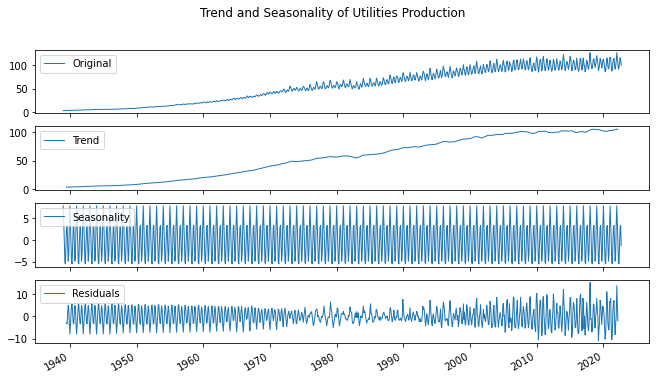

In [168]:
# plotting time series decompose plots of the entire dataset to observe trend and seasonality
df_decompose = df['Production_Index']
ts_decomposition = seasonal_decompose(df_decompose, model='addictive')  # we use addictive here because the trend is linear (multiplicative for non-linear trends)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid
# Plotting the time series and it's components together
fig, axes = plt.subplots(4, 1, figsize=(11,6), sharex=True, sharey=False)
# First plot to the Original time series
axes[0].plot(df_decompose, label='Original', linewidth=1.0) 
axes[0].legend(loc='upper left')
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend', linewidth=1.0)
axes[1].legend(loc='upper left')
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality', linewidth=1.0)
axes[2].legend(loc='upper left')
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals', linewidth=1.0)
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
axes[3].legend(loc='upper left')
plt.gcf().autofmt_xdate() 
fig.suptitle('Trend and Seasonality of Utilities Production')
plt.show()

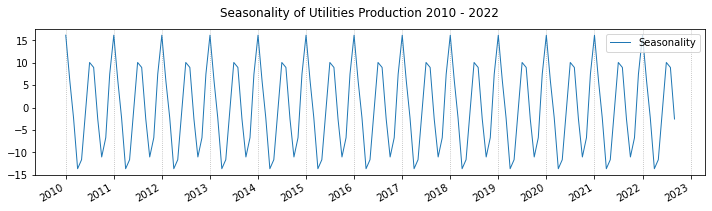

In [169]:
# plotting time series decompose plots of a section of the dataset
df_decompose = df['Production_Index']['2010':'2022']
ts_decomposition = seasonal_decompose(df_decompose, model='addictive')  
seasonal_estimate = ts_decomposition.seasonal
# plotting seasonality component
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(seasonal_estimate, label='Seasonality', linewidth=1.0)
ax.grid(axis='x', ls=':')   # plotting vertical grids
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.legend(loc='upper right')
plt.gcf().autofmt_xdate() 
fig.suptitle('Seasonality of Utilities Production 2010 - 2022')
plt.show()

The decompose analysis has depicted the upward trend of the time series and its 12 month seasonality. This indicates that the time series is not stationary. This is confirmed by the ADF test below which has failed to reject our null hypothesis that the series is non-stationary.

In [170]:
# performing ADF test to test the null hypothesis that the series is non-stationary
df['Production_Index'] = df['Production_Index'].astype('float32')  # convert the data to float32 from float64 to reduce the data size thus prevent memory limitation error
adft = adfuller(df['Production_Index'], autolag="AIC")
adft_df = pd.DataFrame({"Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"], 
                          "Values":[adft[0], adft[1], adft[2], adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]})
print('ADF Test Results:')
print(round(adft_df, 5))  
#print(round(adft_df.style.hie_index(), 5))   # style.hide_index() hides any form of index such as 0,1,2.....
print('\nConclusion:')
if (adft[1] < 0.05) or (adft[0] < adft[4]["5%"]):
    print (">> Reject the null hypothesis - Time series is stationary")
else:
    print (">> Failed to reject the null hypothesis - Time series is non-stationary")

ADF Test Results:
                        Metric     Values
0              Test Statistics   -0.67259
1                      p-value    0.85372
2             No. of lags used   22.00000
3  Number of observations used  982.00000
4          critical value (1%)   -3.43703
5          critical value (5%)   -2.86449
6         critical value (10%)   -2.56834

Conclusion:
>> Failed to reject the null hypothesis - Time series is non-stationary


## Forecasting Utilities Production
Given that the series has both trend and seasonality, we select the statistical methods that would transform the data with both properties into a stationary one.
### SARIMA
Here we deploy auto_arima function, a component of pmdarima library, which automatically tests given combinations of p, d and q values for both autoregressive and seasonality components and determine a set of parameters which yields the best model for the problem.

In [171]:
# modelling a series with seasonality 
sarima_model = auto_arima(df['Production_Index'],
                 start_p=0,  # initial guess for AR(p), p being the number(order) of past observations of the target variable to be considered for forecasting
                 start_d=0,  # initial guess for I(d), p being the number of differencing operations between consecutive observations to be performed on the non-stationary series to make it stationary
                 start_q=0,  # initial guess for MA(q), q being the number of the past error terms of past observations to be considered for forecasting
                 max_p=4,    # max guess for AR(p)
                 max_d=4,    # max guess for I(d)
                 max_q=4,    # max guess for MA(q)
                 seasonal=True,
                 m=12,       # we have yearly seasonality for monthly observations, therefore 12 observations per each season
                 start_P=0,  # initial guess for seasonal AR(P)
                 start_D=0,  # initial guess for seasonal I(D)
                 start_Q=0,  # initial guess for seasonal MA(Q)
                 max_P=3, 
                 max_D=2, 
                 max_Q=3,
                 trend='c',
                 information_criterion='aic', # the function tries to find the model with the lowest AIC (best performance) yielded by the least number of parameters
                 trace=True,
                 error_action='ignore',
                 suppress_warnings=True, 
                 stepwise=True  # runs random seach instead of grid search
                 )
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6325.745, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5486.506, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6325.745, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6047.971, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4226.677, Time=1.23 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4515.698, Time=0.57 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=4223.651, Time=4.11 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=4413.274, Time=1.83 sec
 ARIMA(0,1,1)(3,0,1)[12] intercept   : AIC=4184.455, Time=10.53 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=4282.107, Time=8.79 sec
 ARIMA(0,1,1)(3,0,2)[12] intercept   : AIC=inf, Time=15.78 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=4295.793, Time=8.66 sec
 ARIMA(1,1,1)(3,0,1)[12] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1005
Model:             SARIMAX(2, 1, 1)x(3, 0, 1, 12)   Log Likelihood               -2028.315
Date:                            Wed, 12 Apr 2023   AIC                           4074.630
Time:                                    13:13:55   BIC                           4118.835
Sample:                                01-01-1939   HQIC                          4091.428
                                     - 09-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.001      0.103      0.918      -0.002       0.003
ar.L1          0.5172      0.023     22.332      0.000       0.472       0.563
ar.L2         -0.0263      0.023     -1.130      0.259      -0.072       0.019
ma.L1         -0.9400      0.011    -82.717      0.000      -0.962      -0.918
ar.S.L12       0.9945      0.033     30.147      0.000       0.930       1.059
ar.S.L24      -0.2206      0.030     -7.333      0.000      -0.280      -0.162
ar.S.L36       0.2201      0.025      8.863      0.000       0.171       0.269
ma.S.L12      -0.6464      0.035    -18.362      0.000      -0.715      -0.577
sigma2         3.1633      0.089     35.588      0.000       2.989       3.338
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               651.72
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              94.30   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

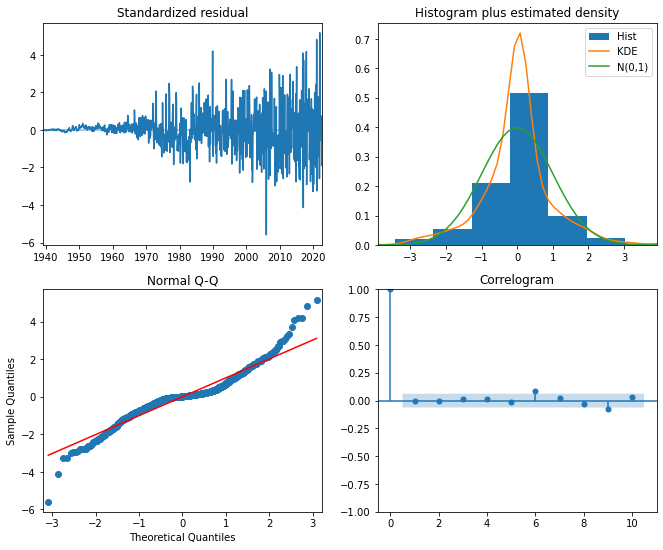

In [172]:
# run model diagnostics
sarima_model.plot_diagnostics(figsize=(11,9))
plt.show()

The model diagnostic produces four plots indicated above. Below is the interpretation of the plots:
1. Standardized residual - There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance. For a perfect model, the variance should be constant. This shows that our best model has not completely transformed the series to a strong stationary form.
2. Histogram plus KDE estimate - The KDE and histogram curves have taken a pattern nearly similar to that of normal distribution (labeled as N(0,1) in the plot) but ideally they should be exactly the same with the N(0,1) for a perfect fit.
3. Normal Q-Q - A number of observations are falling within the line but there is a significant number of observations are still away from the line, showing a certain degree of errors to the model.
4. Correlogram (ACF plot) - The model has managed to lower the correlation values of all the lags below the threshold of significance (the gray area) except the two, indicating that it has fitted the data to a large extent.
In conclusion, our best model has fitted the data to a large extent but also it has generated significant errors.

In [173]:
# splitting the dataset into train and test data
df_train = df.loc['1990-01-01':'2018-12-31']
df_test = df.loc['2019-01-01':'2022-09-01']
print('Train dataset size: ', len(df_train))
print('Test dataset size: ', len(df_test))

Train dataset size:  348
Test dataset size:  45


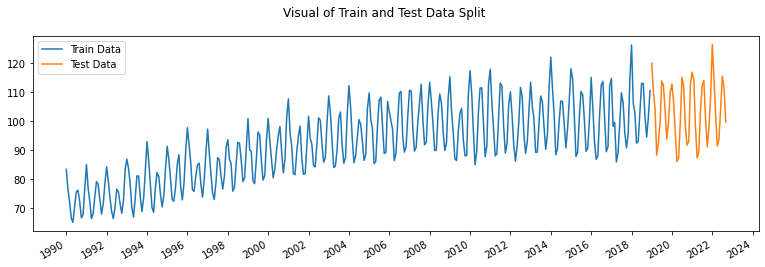

In [174]:
# visualizing train and test datasets
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(df_train['Production_Index'], label='Train Data')
ax.plot(df_test['Production_Index'], label='Test Data')
#ax.axvline('2018-12-31', color='black', linestyle='--', linewidth=0.6)
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
fig.suptitle('Visual of Train and Test Data Split')
plt.show()

In [175]:
# make predictions
sarima_model.fit(df_train['Production_Index'])
forecast_sarima = sarima_model.predict(n_periods=len(df_test['Production_Index']))
# convert the predictions to dataframe
df_forecast_sarima = pd.DataFrame(forecast_sarima, index = df_test.index, columns=['Predictions'])

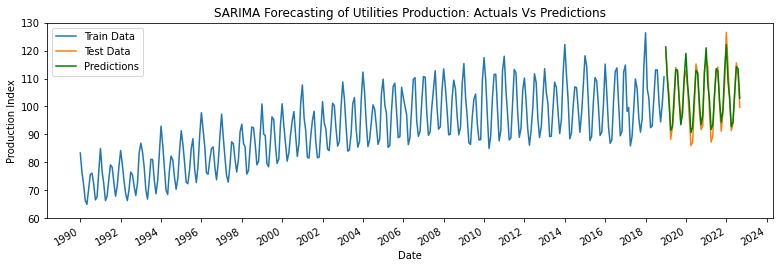

In [176]:
# visualizing actuals and predictions
fig, ax = plt.subplots(figsize=(13,4))
#ax.plot(df['Energy_Output'].loc['1995-01-01':'2022-09-01'], label='Actuals')  # reduce the period of original data for image clarity
ax.plot(df_train['Production_Index'].loc['1990-01-01':'2018-12-31'], label='Train Data')  # reduce the period of training data for image clarity
ax.plot(df_test['Production_Index'], label='Test Data')
ax.plot(df_forecast_sarima, color='green', label='Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_title('SARIMA Forecasting of Utilities Production: Actuals Vs Predictions')
fig.suptitle('')
ax.set_ylim([60.0, 130.0])
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.legend(loc='best')
plt.gcf().autofmt_xdate() # auto format font and rotation for date tick labels
plt.show()

In [177]:
# generating the model's performance measures
MAPE = round(mean_absolute_percentage_error(df_test['Production_Index'].values, df_forecast_sarima.values), 4)
MAE = round(mean_absolute_error(df_test['Production_Index'].values, df_forecast_sarima.values), 3)
RMSE = round(np.sqrt(mean_squared_error(df_test['Production_Index'].values, df_forecast_sarima.values)), 3)
print('MAPE: ', MAPE*100, '% | ', 'MAE: ', MAE, ' | ', 'RMSE: ', RMSE)

MAPE:  2.44 % |  MAE:  2.479  |  RMSE:  3.079


The model has a MAPE of 2.44% meaning that the accuracy in forecasting the 45 periods is 97.56%

In [178]:
# We now forecast utility production for the next 3 years using the model
# first, we combine former train and test datasets to make a new train dataset
new_df_train = pd.concat([df_train, df_test], axis=0)   # appending the second dataframe to the first one
# make predictions
prediction_time = 36  # period of forecasting (36 months)
sarima_model.fit(new_df_train['Production_Index'])
forecast_sarima = sarima_model.predict(n_periods=prediction_time)  
# convert the predictions to dataframe
df_new_forecast = pd.DataFrame(forecast_sarima, index = pd.date_range(start='2022-10-01', periods=prediction_time, freq='MS'), columns=['Predictions'])
df_new_forecast

,Predictions
2022-10-01,93.390304
2022-11-01,101.071296
2022-12-01,110.863208
2023-01-01,119.324197
2023-02-01,110.059034
2023-03-01,100.048475
2023-04-01,90.918416
2023-05-01,92.976783
2023-06-01,103.367569
2023-07-01,114.533124


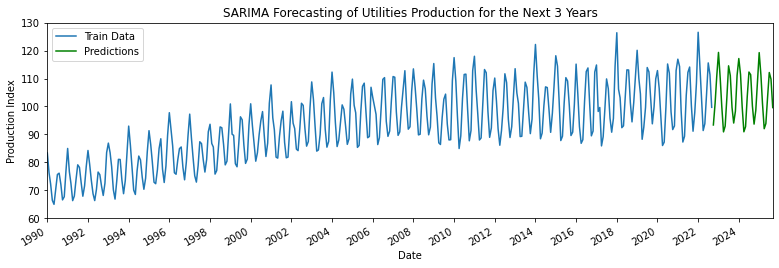

In [185]:
# visualizing actuals and predictions
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(new_df_train['Production_Index'], label='Train Data')  # reduce the period of training data for image clarity
ax.plot(df_new_forecast, color='green', label='Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('2025-09-01'))
ax.set_title('SARIMA Forecasting of Utilities Production for the Next 3 Years')
fig.suptitle('')
ax.set_ylim([60.0, 130.0])
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.show()

### Prophet
We deploy Meta's forecasting library, Prophet, which uses a statistical based approach to forecast time series consisting of trends, seasonality and holidays

In [180]:
# renaming date and energy output columns as per prophet's requirement
df = df_prophet
df = df.rename(columns={'Observation_Date':'ds','Production_Index':'y'}) # converting the two columns to the required names by prophet
df.sort_values(by='ds', inplace=True)
df.head()

,ds,y
0,1939-01-01,3.3335
1,1939-02-01,3.3590
2,1939-03-01,3.4353
3,1939-04-01,3.4607
4,1939-05-01,3.4607


In [181]:
# partitioning training and testing data
df_train = df.loc[df['ds'].dt.year <= 2018]   # partitioning using date objects. Train data 1939 - 2019
df_test = df.loc[df['ds'].dt.year > 2018]    # Test data 2020 - 2022
# defining the model with adjusted default values of some parameters before fitting it to the data
model_prt = Prophet(
                    changepoint_prior_scale=0.5, # default is 0.05. We increase the sparse prior to allow enough flexibility to the model to detect more change points
                    growth='linear', # the series seems to grow linearly without having saturation point, thus non-logistic
                    yearly_seasonality=True, # based on the observed 12 month seasonality
                    seasonality_mode='multiplicative' # the magnitude of seasonality grows exponentially with time as per observed series. Default is 'addictive' meaning the magnitude is constant
                    )
model_prt.fit(df_train)
# make predictions
future_periods = model_prt.make_future_dataframe(periods=len(df_test), freq='MS')
df_forecast_prt = model_prt.predict(future_periods)  # this returns predictions of an entire dataset onstead of testing dataset only!!
df_forecast_prt[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # yhat_lower and yhat_upper are prediction confidence/intervals

13:14:05 - cmdstanpy - INFO - Chain [1] start processing
13:14:06 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,1939-01-01,3.857185,1.211465,6.586490
1,1939-02-01,3.630488,1.077171,6.313222
2,1939-03-01,3.438483,0.685118,6.250576
3,1939-04-01,3.105718,0.348423,6.062302
4,1939-05-01,3.116296,0.127158,5.764388
...,...,...,...,...
1000,2022-05-01,94.084959,90.934265,97.388408
1001,2022-06-01,102.963190,99.757575,106.054095
1002,2022-07-01,111.653338,108.338508,114.862462
1003,2022-08-01,112.453456,109.074587,115.846222


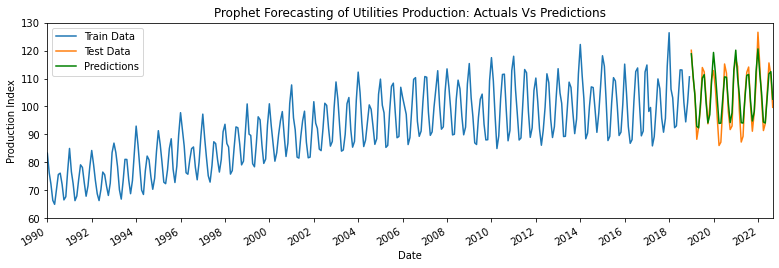

In [182]:
# set 'ds' as index for simplifying plotting
df_train = df_train.set_index('ds')
df_test = df_test.set_index('ds')
df_forecast_prt = df_forecast_prt.set_index('ds')
# plot train and test data against predictions
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(df_train['y'], label='Train Data')
ax.plot(df_test['y'], label='Test Data')
ax.plot(df_forecast_prt['yhat'].loc['2019-01-01':'2022-09-01'], color='green', label='Predictions') # limiting the forecasted values to have the same index range as testing data
ax.set_xlabel("Date")
ax.set_ylabel("Production Index")
ax.set_xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('2022-09-01')) # limiting index period for visual clarity
ax.set_title('Prophet Forecasting of Utilities Production: Actuals Vs Predictions')
fig.suptitle('')
ax.set_ylim([60.0, 130.0])
# set yearly locator
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.legend(loc='best')
plt.gcf().autofmt_xdate() 
plt.show()

In [183]:
# generating the model's performance measures
MAPE = round(mean_absolute_percentage_error(df_test['y'].values, df_forecast_prt['yhat'].loc['2019-01-01':'2022-09-01'].values), 3)
MAE = round(mean_absolute_error(df_test['y'].values, df_forecast_prt['yhat'].loc['2019-01-01':'2022-09-01'].values), 3)
RMSE = round(np.sqrt(mean_squared_error(df_test['y'].values, df_forecast_prt['yhat'].loc['2019-01-01':'2022-09-01'].values)), 3)
print('MAPE: ', MAPE*100, '% | ', 'MAE: ', MAE, ' | ', 'RMSE: ', RMSE)

MAPE:  3.0 % |  MAE:  2.994  |  RMSE:  3.67


Based on the visuals of predictions of the models and their performance measures, we clearly see that SARIMA has performed better for this problem than Prophet.